In [1]:
import pandas as pd
import numpy as np
import re
import os
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import datetime as dt

In [2]:
# Load data 
news = pd.read_csv('News_DJIA.csv')
price = pd.read_csv('Value_DJIA.csv')
price['Adj Close Tmrw'] = price['Adj Close'].shift(-1)
price['ReLabel'] = price.apply(lambda x: 1 if (x['Adj Close Tmrw']> x['Adj Close']) else 0, axis =1)

In [3]:
news.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [4]:
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Adj Close Tmrw,ReLabel
0,2008-01-02,13261.820313,13279.540039,12991.370117,13043.959961,13043.959961,239580000,13056.719727,1
1,2008-01-03,13044.120117,13137.929688,13023.559570,13056.719727,13056.719727,200620000,12800.179688,0
2,2008-01-04,13046.559570,13046.719727,12789.040039,12800.179688,12800.179688,304210000,12827.490234,1
3,2008-01-07,12801.150391,12884.150391,12733.839844,12827.490234,12827.490234,306700000,12589.070313,0
4,2008-01-08,12820.900391,12906.419922,12565.410156,12589.070313,12589.070313,322690000,12735.309570,1


<AxesSubplot:>

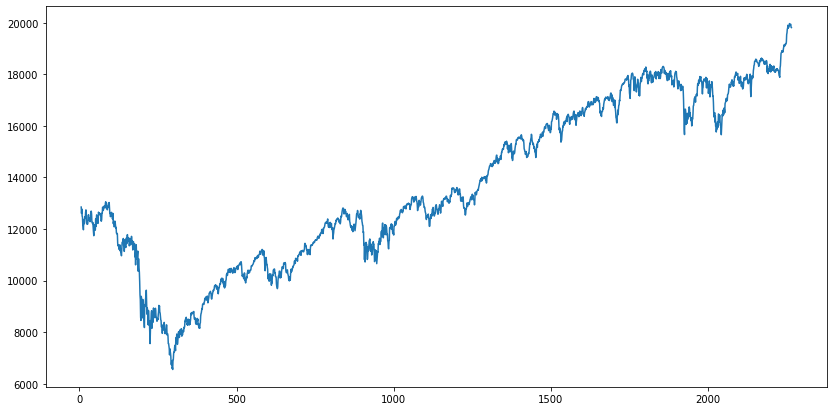

In [5]:
#Plot of Closing Price
price[price['Date'] >= "2008-01-10"].Close.plot(figsize=(14, 7))

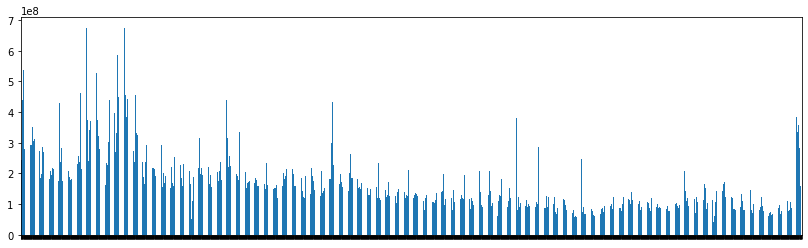

In [6]:
#Volume Plot
price[price['Date'] >= "2008-01-10"].Volume.plot(kind="bar", figsize=(14, 4))
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)

In [7]:
title_cols = list(news.columns[2:24]) # using Top 22 titles due to BERTs max sequence length of 512
news['News'] = news[title_cols].agg(' '.join, axis = 1)

In [8]:
headlines=[]
for row in range(0,len(news.index)):
    headlines.append(''.join(str(x) for x in news.iloc[row,2:27]))

In [9]:
#Clean the data
clean_headlines=[]

for i in range(0,len(headlines)):
    clean_headlines.append(re.sub('b[(\')]','',headlines[i]))
    clean_headlines[i] = re.sub('b[(\")]','',clean_headlines[i])
    clean_headlines[i] = re.sub("\'",'',clean_headlines[i])

In [10]:
news['Combined_News']=clean_headlines

In [11]:
#Get Polarity and Subjectivity
news[['Polarity','Subjectivity']] = news['Combined_News'].apply(lambda text: pd.Series(TextBlob(text).sentiment))

In [12]:
#Get Negative, Positive, Neutral and Compound Values
for index,row in news['Combined_News'].iteritems():
    score=SentimentIntensityAnalyzer().polarity_scores(row)
    neg=score['neg']
    neu=score['neu']
    pos=score['pos']
    comp=score['compound']
    
    news.loc[index,'Negative']=neg
    news.loc[index,'Positive']=pos
    news.loc[index,'Neutral']=neu
    news.loc[index,'Compound']=comp

In [13]:
# merge price to news
data = news.merge(price, how='inner', on='Date')
data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Neutral,Compound,Open,High,Low,Close,Adj Close,Volume,Adj Close Tmrw,ReLabel
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,0.724,-0.9966,11432.089844,11759.959961,11388.040039,11734.320313,11734.320313,212830000,11782.349609,1
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,0.761,-0.9457,11729.669922,11867.110352,11675.530273,11782.349609,11782.349609,183190000,11642.469727,0
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,0.805,-0.9739,11781.700195,11782.349609,11601.519531,11642.469727,11642.469727,173590000,11532.959961,0
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,0.797,-0.9805,11632.809570,11633.780273,11453.339844,11532.959961,11532.959961,182550000,11615.929688,1
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,0.723,-0.9831,11532.070313,11718.280273,11450.889648,11615.929688,11615.929688,159790000,11659.900391,1


In [14]:
data['Date'] = pd.to_datetime(data['Date'])

In [51]:
data

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top25,News,Open,High,Low,Close,Adj Close,Volume,Adj Close Tmrw,ReLabel
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,"b""No Help for Mexico's Kidnapping Surge""","b""Georgia 'downs two Russian warplanes' as cou...",11432.089844,11759.959961,11388.040039,11734.320313,11734.320313,212830000,11782.349609,1
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,"b""So this is what it's come to: trading sex fo...",b'Why wont America and Nato help us? If they w...,11729.669922,11867.110352,11675.530273,11782.349609,11782.349609,183190000,11642.469727,0
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",b'Remember that adorable 9-year-old who sang a...,11781.700195,11782.349609,11601.519531,11642.469727,11642.469727,173590000,11532.959961,0
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,b' U.S. refuses Israel weapons to attack Iran:...,11632.809570,11633.780273,11453.339844,11532.959961,11532.959961,182550000,11615.929688,1
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,b'Philippines : Peace Advocate say Muslims nee...,b'All the experts admit that we should legalis...,11532.070313,11718.280273,11450.889648,11615.929688,11615.929688,159790000,11659.900391,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,2016-06-27,0,Barclays and RBS shares suspended from trading...,Pope says Church should ask forgiveness from g...,Poland 'shocked' by xenophobic abuse of Poles ...,"There will be no second referendum, cabinet ag...","Scotland welcome to join EU, Merkel ally says",Sterling dips below Friday's 31-year low amid ...,No negative news about South African President...,Surge in Hate Crimes in the U.K. Following U.K...,...,Pakistani clerics declare transgender marriage...,Barclays and RBS shares suspended from trading...,17355.210938,17355.210938,17063.080078,17140.240234,17140.240234,138740000,17409.720703,1
1985,2016-06-28,1,"2,500 Scientists To Australia: If You Want To ...","The personal details of 112,000 French police ...",S&amp

In [24]:
# split news to train and test
split = dt.datetime(2015,1,1,0,0,0)
train = data[data.Date <= split]
test = data[data.Date > split]
keep_columns=['Open','High','Low','Volume','Subjectivity','Polarity','Compound','Negative','Positive','Label']
X_train, y_train = np.array(train[keep_columns]),np.array(train['ReLabel'])
X_test, y_test = np.array(test[keep_columns]),np.array(test['ReLabel'])

# normalize X's
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

models = {  'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis(), 'SVM Classification': SVC(), 'SGDClassifier': SGDClassifier(loss="hinge", penalty="l2", max_iter=100), 'KNeighborsClassifier':KNeighborsClassifier(n_neighbors=10),'GaussianProcessClassifier': GaussianProcessClassifier(),'RandomForestClassifier': RandomForestClassifier(n_estimators=100)}

for model_name in models.keys():

    model = models[model_name]
    print('--------------',model_name,'---------------')
    model.fit(X_train,y_train)
    print(classification_report(model.predict(X_test),y_test))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


-------------- LinearDiscriminantAnalysis ---------------
              precision    recall  f1-score   support

           0       0.34      0.55      0.42       116
           1       0.73      0.53      0.61       262

    accuracy                           0.54       378
   macro avg       0.53      0.54      0.52       378
weighted avg       0.61      0.54      0.55       378

-------------- SVM Classification ---------------
              precision    recall  f1-score   support

           0       0.12      0.44      0.19        52
           1       0.85      0.50      0.63       326

    accuracy                           0.49       378
   macro avg       0.49      0.47      0.41       378
weighted avg       0.75      0.49      0.57       378

-------------- SGDClassifier ---------------
              precision    recall  f1-score   support

           0       0.47      0.51      0.49       171
           1       0.56      0.52      0.54       207

    accuracy                 